In [2]:
%matplotlib inline
%matplotlib notebook

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import to_datetime
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d

In [47]:
filenames = ['data/189_2014.txt']

raw_data = []
for f in filenames:
    raw_data = np.concatenate((raw_data, np.loadtxt(f, delimiter=',', skiprows=1, dtype=str)))
date_data = np.genfromtxt((i[:-2] if i[-1] == '3' else '' for i in raw_data), delimiter=';', 
                     dtype=[('date', 'U19'), ('height', 'float')])

In [48]:
file = open("data.txt", "w")
beginning = np.datetime64(to_datetime(date_data[0][0], dayfirst=True), 's')
for d in date_data:
    file.writelines([str(np.datetime64(to_datetime(d[0], dayfirst=True), 's'))+';', 
                     str((np.datetime64(to_datetime(d[0], dayfirst=True), 's')
                          -beginning).item().total_seconds())+';', str(d[1])+'\n'])
file.close()

## import

In [4]:
data = np.genfromtxt('data.txt', delimiter=";", usecols = range(1,3))
dates = np.genfromtxt('data.txt', dtype='datetime64[s]', delimiter=";", usecols = range(0,1))

<IPython.core.display.Javascript object>


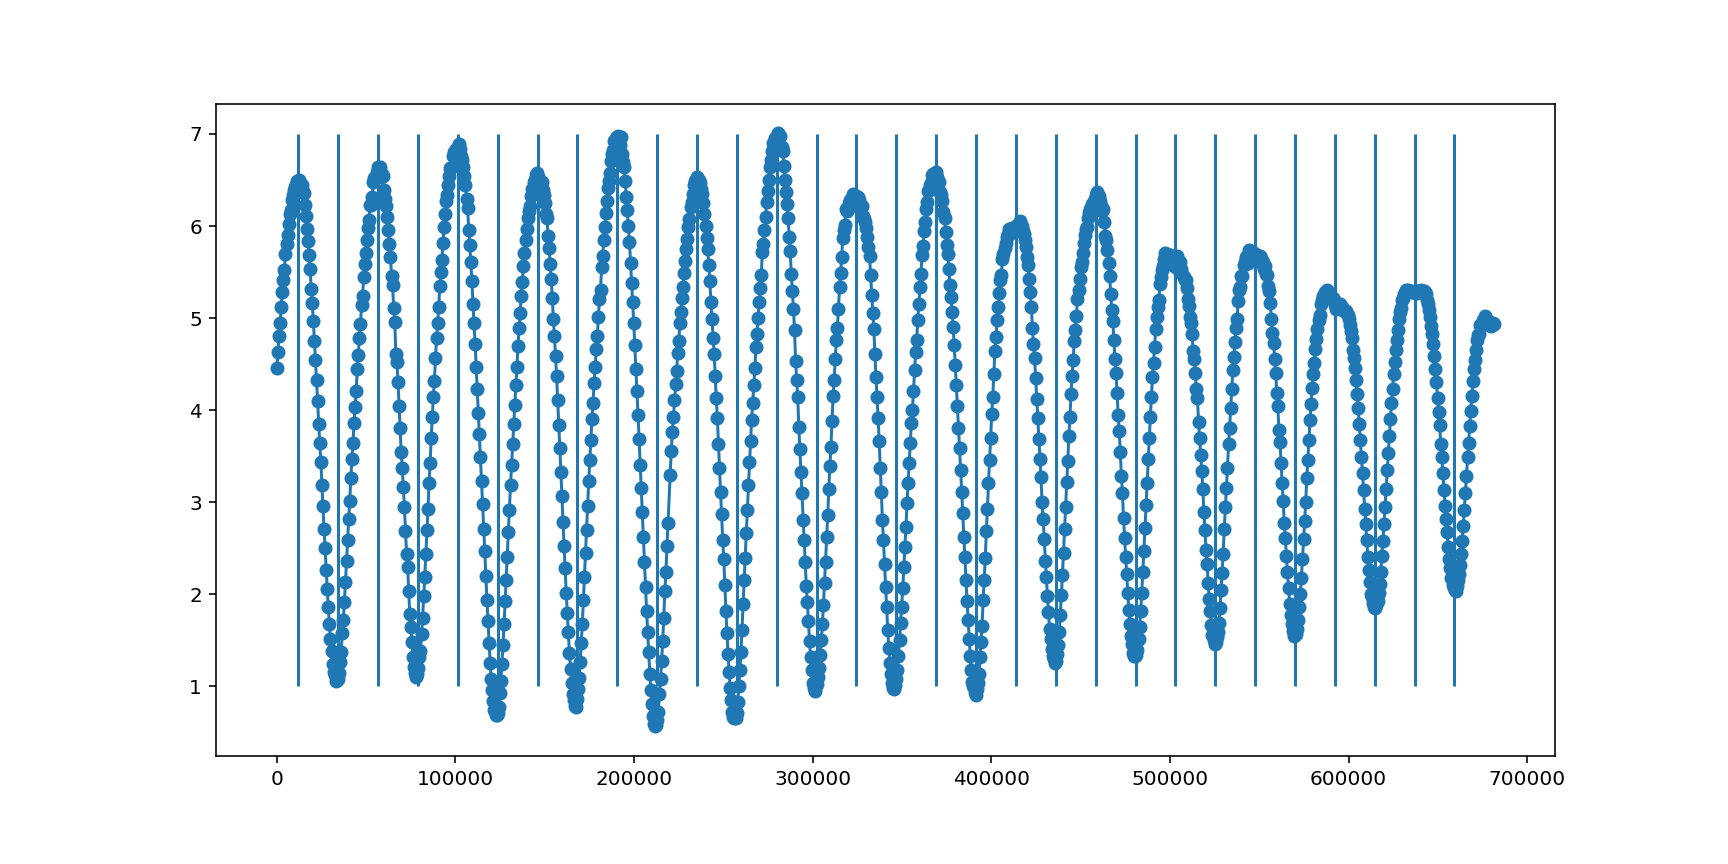

In [5]:
plt.rcParams["figure.figsize"] = (12,6)
period = (6*60 + 12) * 60
offset = 12000
n = 30
l = int((n*period + offset)/600)
mean_height = np.mean(data[:,1])

plt.plot(data[:l,0], data[:l,1], 'o-')
for i in range(n):
    plt.vlines(i*period+offset, 1, 7)

<IPython.core.display.Javascript object>


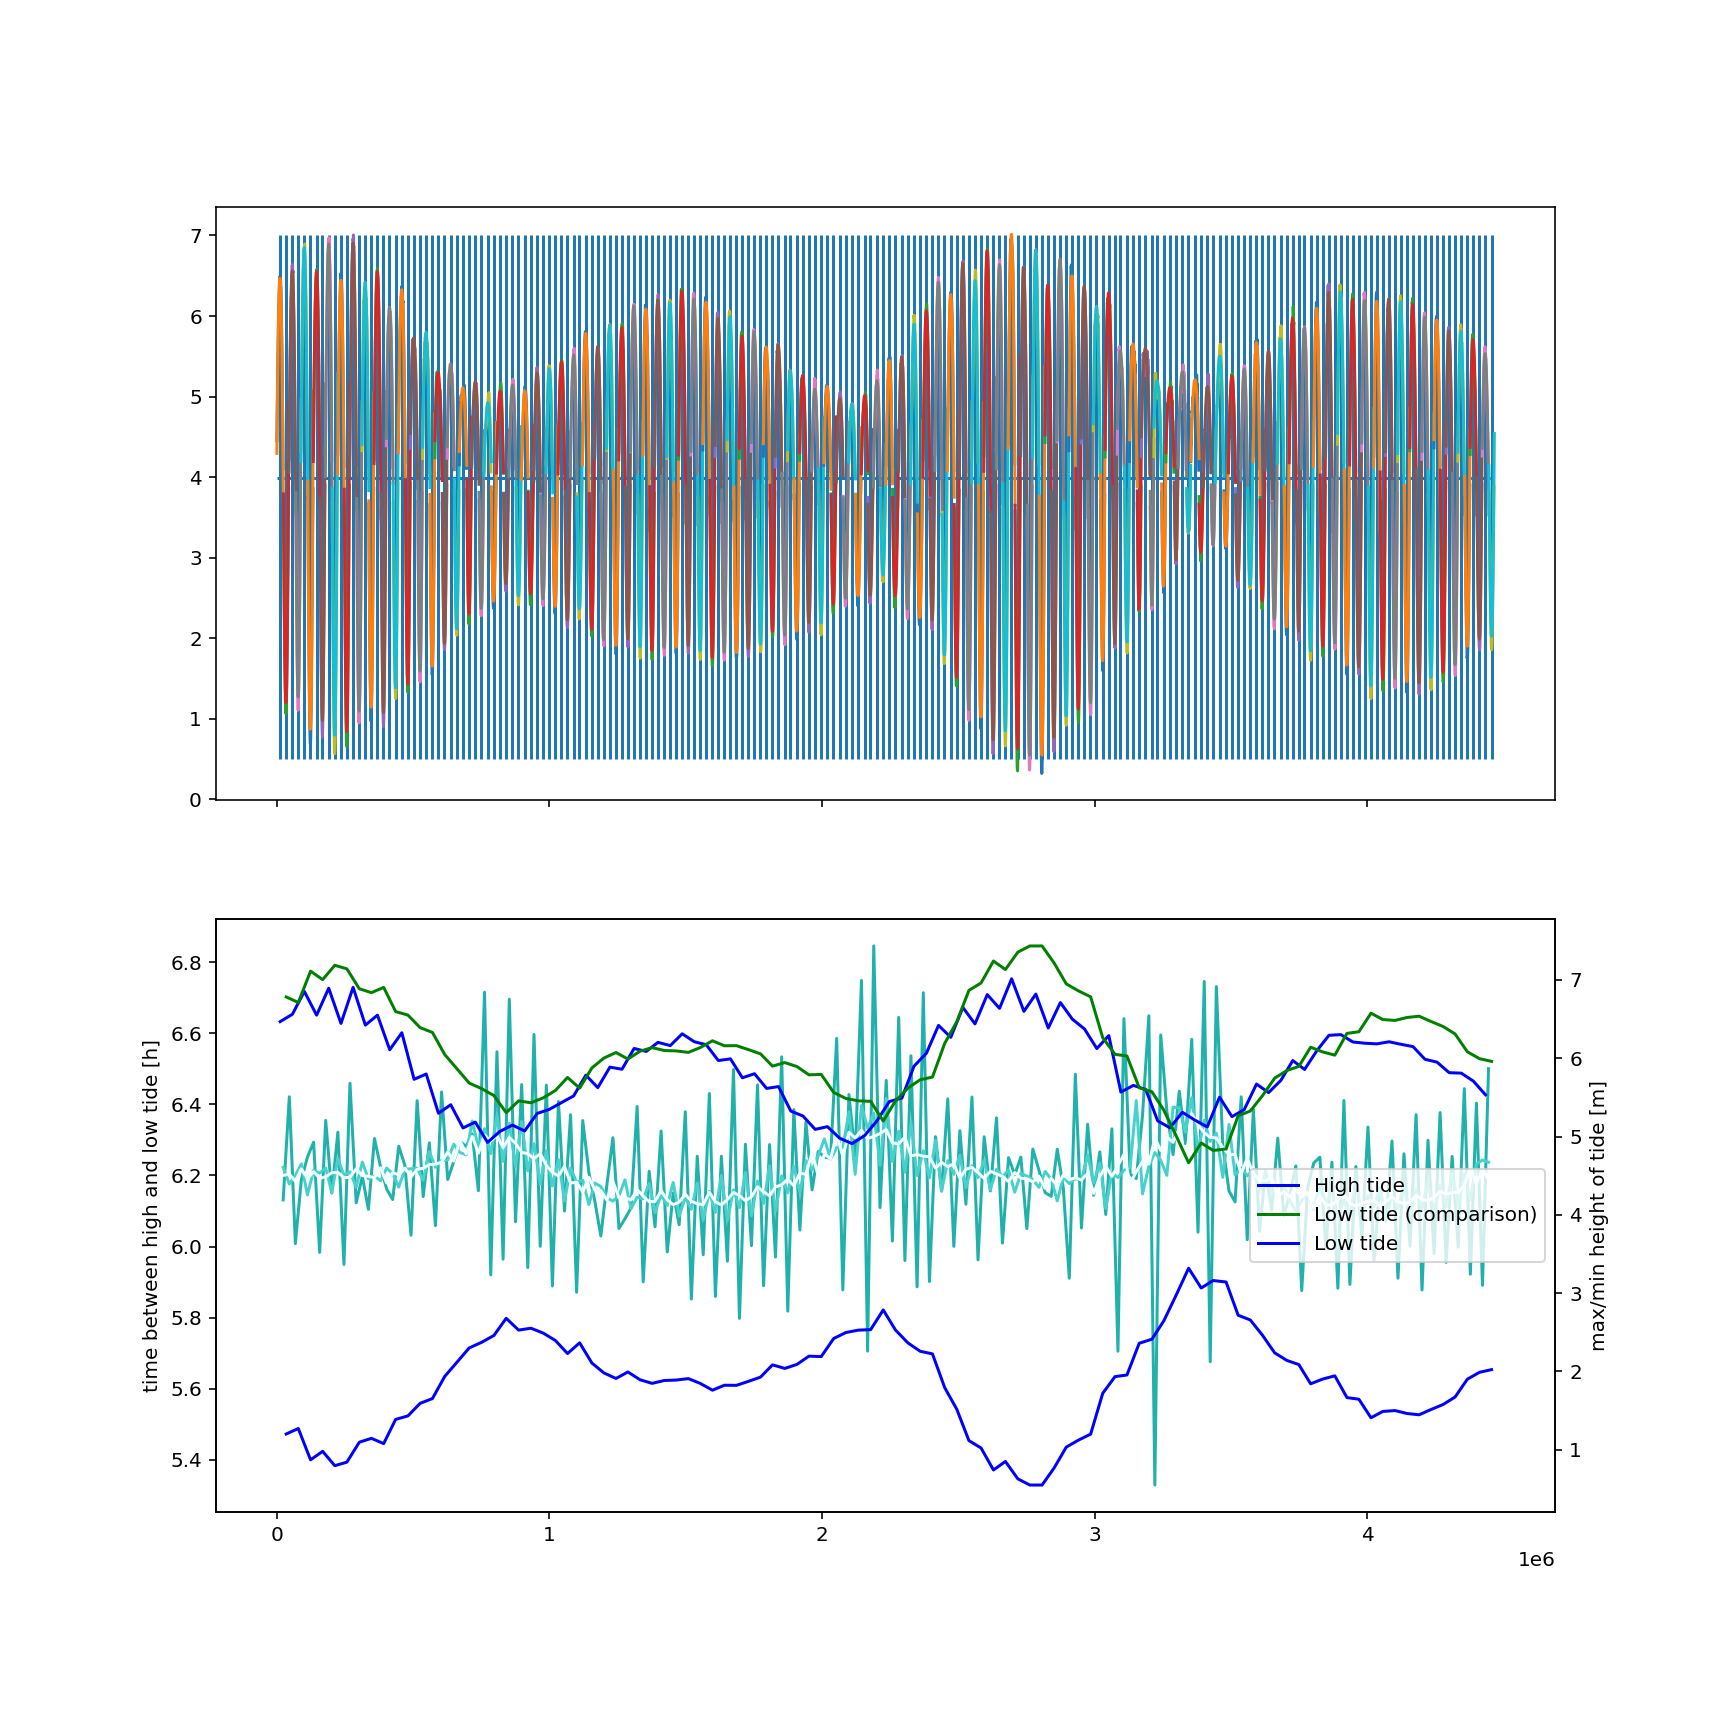

In [8]:
def f(x, a, b, c):
    return a * (x - b)**2 + c

max_list = []

n = 200

plt.rcParams["figure.figsize"] = (12, 12) 
fig, ax = plt.subplots(2, sharex=True)

index_start = 0
index_end = 1
while np.sign(data[index_start, 1]-mean_height) == np.sign(data[index_end-1, 1]-mean_height):
    index_end += 1

for i in range(n):
    cut_data = data[(data[:,0] < data[index_end-1, 0])&(data[:,0] >= data[index_start, 0])]
    ax[0].plot(cut_data[:,0], cut_data[:,1])
    params = curve_fit(f, cut_data[:,0], cut_data[:,1], [0, data[index_start + (index_end - index_start)//2, 0], 0])
    ax[0].plot(np.linspace(data[index_start, 0], data[index_end, 0], 1000), f(np.linspace(data[index_start, 0], data[index_end, 0], 1000), params[0][0], params[0][1], params[0][2]))
    ax[0].vlines(params[0][1], 0.5, 7)
    max_list.append([data[index_start + (index_end - index_start)//2, 0], params[0][1], params[0][2]])
    index_start = index_end
    if i == n-1:
        ax[0].hlines(mean_height, 0, data[index_start, 0])
    while np.sign(data[index_start, 1]-mean_height) == np.sign(data[index_end-1, 1]-mean_height):
        if index_end + 1 > len(data):
            break
        index_end += 1
    if index_end + 1 > len(data):
        break

max_list = np.array(max_list)

max_diff = np.array([[max_list[i, 0] + (max_list[i+1, 0]-max_list[i, 0])/2, (max_list[i+1, 1]-max_list[i, 1])/3600] 
                     for i in range(len(max_list)-1)])
ax[1].plot(max_diff[:,0], max_diff[:,1], zorder=0, color='lightseagreen')
ax[1].plot(max_diff[:,0], uniform_filter1d(max_diff[:,1], size=5), zorder=1, color='mediumturquoise')
ax[1].plot(max_diff[:,0], uniform_filter1d(max_diff[:,1], size=10), zorder=2, color='azure')
ax[1].set_ylabel('time between high and low tide [h]')

ax2 = ax[1].twinx()

ax2.plot(max_list[0::2,0], max_list[0::2,2], color='b', label='High tide')
ax2.plot(max_list[1::2,0], 2*mean_height-max_list[1::2,2], color='g', label='Low tide (comparison)')
ax2.plot(max_list[1::2,0], max_list[1::2,2], color='b', label='Low tide')
ax2.set_ylabel('max/min height of tide [m]')
ax2.legend()

## there is a negative correlation betweenn time between high and low tide and the amplitude of the tides

Wenn der Mond und die Sonne sich aus der Sicht der Erde annähern, dann verkürtzt sich die Zeit zwischen zwei Tiden, da die Tiden der Sonne und des Mondes immer näher aneinanderrücken. Die Amplitude wird aber größer wenn sich Sonne und Mond annähern, also gibt es eine negative Korrelation zwischen diesen beiden Messgrößen.

# Fourier ganz nützlich, vielleicht v3